In [13]:
%load_ext autoreload
%autoreload 2
from lab.postprocessing.toolbox import *
from lab.postprocessing.visualization import get_grid_points, make_violin_plot
from lab.data.datasets import SyntheticDataset
from matplotlib import pyplot as plt
from matplotlib import cm
from matplotlib.colors import ListedColormap
import torch
import os
import numpy as np

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [14]:
result_dir = '/home/iai/user/conrads/rnn-cnn/results'

In [15]:
def plot_data(dataset, n_samples=int(2e4)):
    input = dataset.input[:n_samples]
    target = dataset.target[:n_samples]
    class1 = input[target == 0]
    class2 = input[target == 1]

    plt.scatter(class1[:, 0], class1[:, 1], c='darkred', s=1, label='class 1')
    plt.scatter(class2[:, 0], class2[:, 1], c='midnightblue', s=1, label='class 2')
    plt.legend()
    plt.xlim(-4, 4.5)
    plt.ylim(-4, 4.5)
    plt.xticks([])
    plt.yticks([])

# custom colormap
cw = cm.get_cmap('coolwarm', 1000)
CMAP = ListedColormap(cw(np.linspace(0, 1, 1000)[300:700]))

# points to evaluate
POINTS = get_grid_points(-4, 4.5, -4, 4.5, step_size=.03)

def plot_decision(logits):
    y = torch.argmax(logits, dim=-1)

    plt.figure(figsize=(7, 5), dpi=150)

    y = torch.nn.functional.softmax(logits, dim=1)[:, 0]
    plt.scatter(POINTS[:, 0], POINTS[:, 1], c=y.cpu(), s=10, cmap=CMAP)
    cbar = plt.colorbar()
    cbar.set_label('probability of class 1')
    
def plot_recs(final_steps):
    plt.figure(figsize=(5, 5), dpi=150)
    plt.scatter(POINTS[:, 0][final_steps == 0],
                POINTS[:, 1][final_steps == 0],
                c='white', s=10, label='1 recurrence')
    plt.scatter(POINTS[:, 0][final_steps == 1],
                POINTS[:, 1][final_steps == 1],
                c='bisque', s=10, label='2 recurrences')

# Data

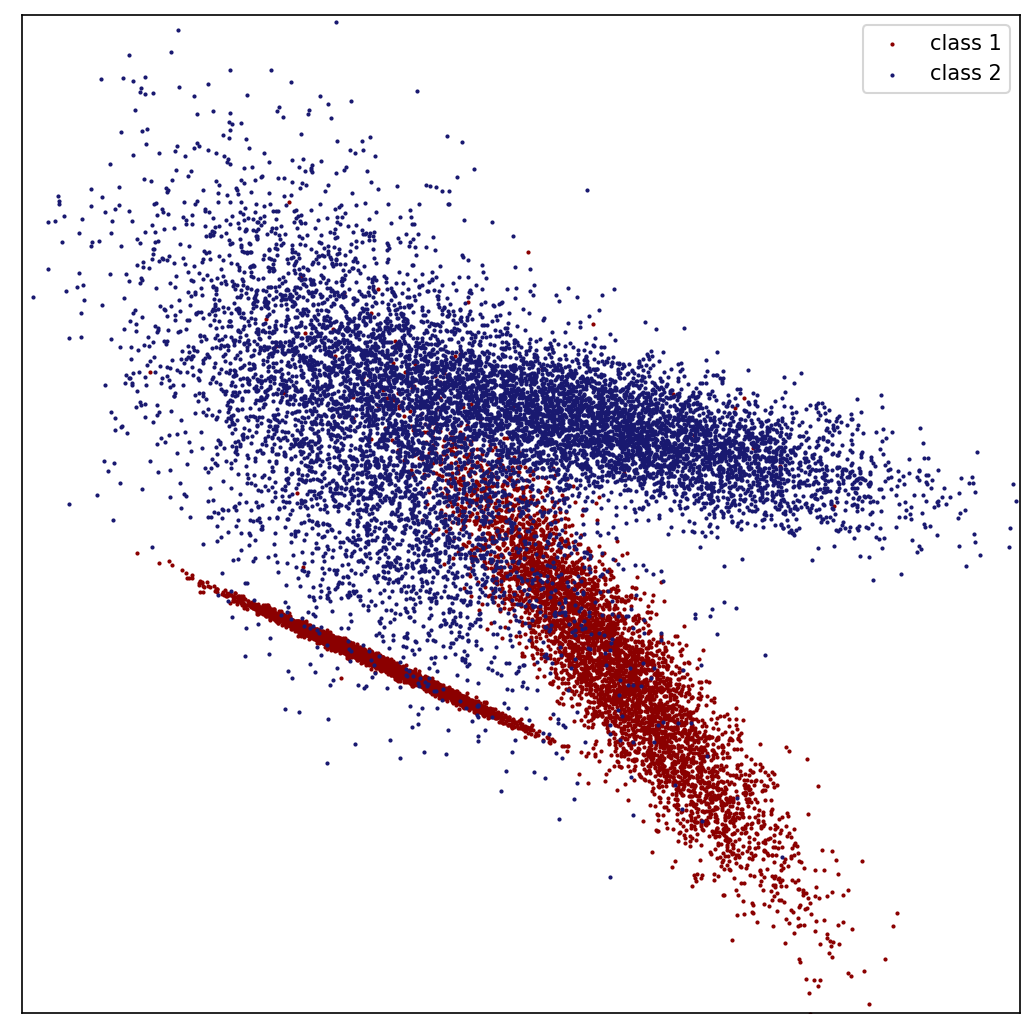

In [16]:
dataset = SyntheticDataset(device='cpu', seed=1)
plt.figure(figsize=(7, 7), dpi=150)
plot_data(dataset)
plt.tight_layout()
plt.savefig(os.path.join(result_dir, 'images/synth2d'))

# MLP 3 layers

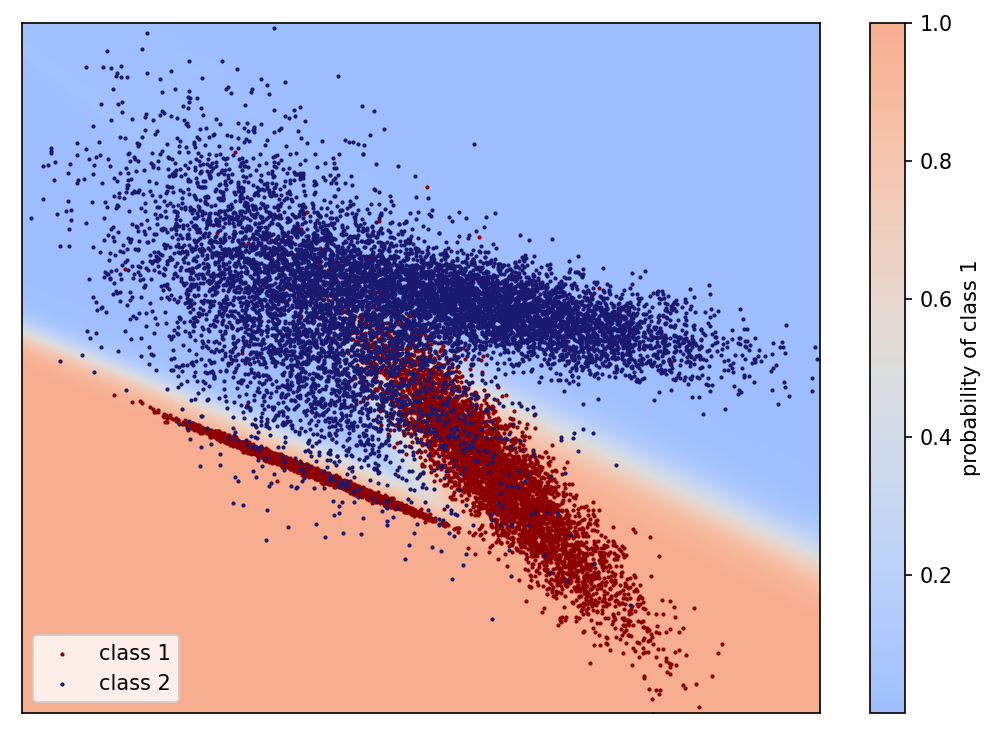

In [15]:
model_name = 'synth_hard/mlp_cv/_model_layer_dims_(2, 2)/0601-142912'

model, loader = load_model(result_dir, model_name)

# evaluate model for all points in the plane
logits = model(POINTS.to(model.device))
plot_decision(logits)
plot_data(dataset)
plt.tight_layout()
plt.savefig(os.path.join(result_dir, 'images/synth2d_mlp3'))

# MLP 4 layers

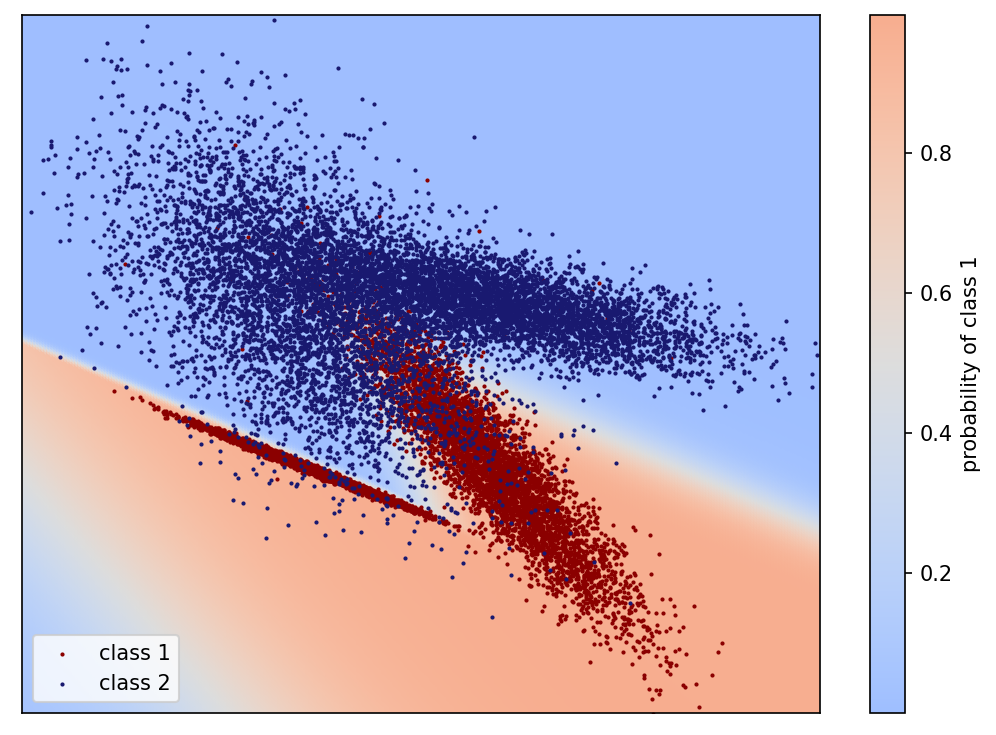

In [16]:
model_name = 'synth_hard/mlp_cv/_model_layer_dims_(2, 2, 2)/0601-122607'

model, loader = load_model(result_dir, model_name)

# evaluate model for all points in the plane
logits = model(POINTS.to(model.device))
plot_decision(logits)
plot_data(dataset)
plt.tight_layout()
plt.savefig(os.path.join(result_dir, 'images/synth2d_mlp4'))

# RNN


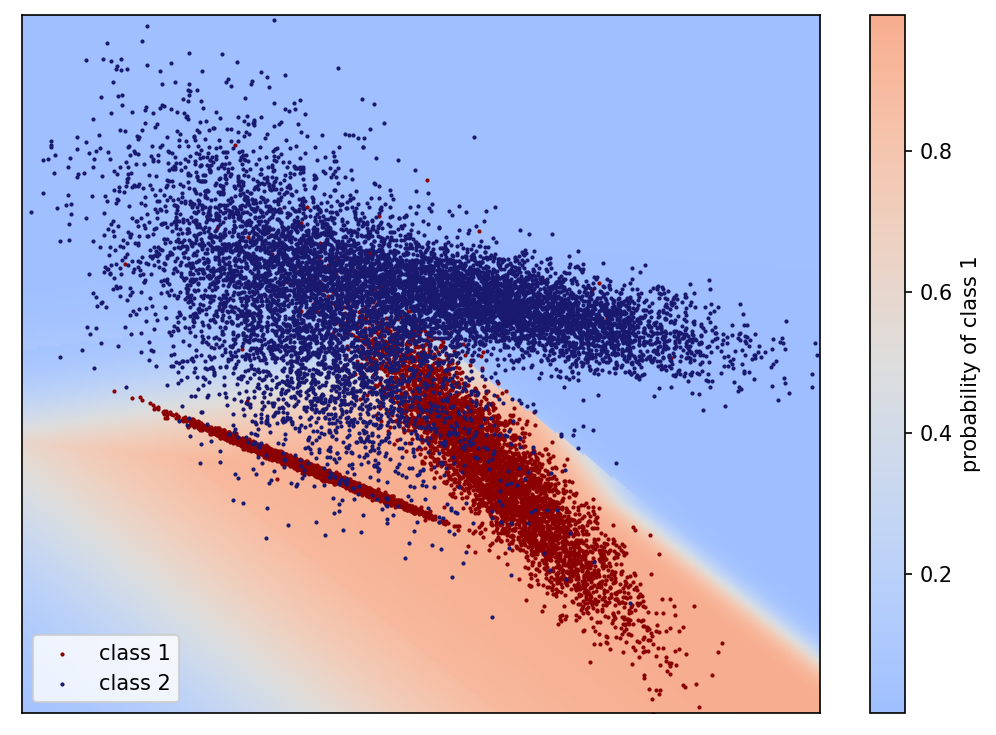

In [11]:
result_dir = '/home/iai/user/conrads/rnn-cnn/results'
model_name = 'synth2d/rnn/_model_rnn_type_linear_model_stopping_criterion_threshold_model_threshold_0.9/0729-173017'

model, _ = load_model(result_dir, model_name)

logits_stacked = model(POINTS.to(model.device))
final_steps = get_final_steps(model, POINTS.to(model.device), logits_stacked)
if final_steps.dim() == 2:
    final_steps = torch.argmax(final_steps, dim=-1)
logits = model.get_final_logits(logits_stacked, final_steps)

plot_decision(logits)
plot_data(dataset)
plt.tight_layout()
plt.savefig(os.path.join(result_dir, 'images/synth2d_rnn_dec'))

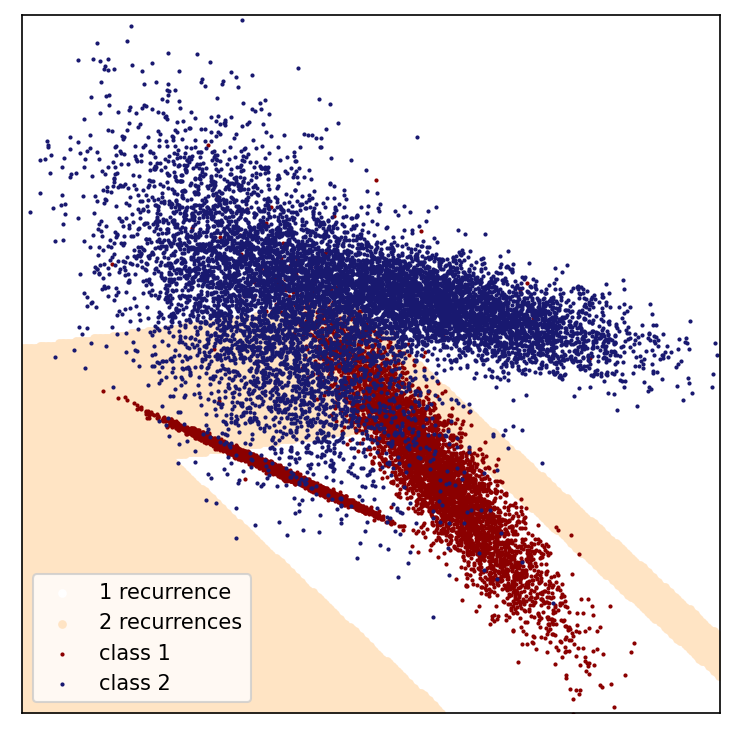

In [12]:
plot_recs(final_steps)
plot_data(dataset)
plt.tight_layout()
plt.savefig(os.path.join(result_dir, 'images/synth2d_rnn_rec'))

In [21]:
model_dir = 'synth2d/mlp/_model_layer_dims_(2, 2)'
acc_mlp2 = load_and_evaluate_dir(result_dir, model_dir)

accuracy:  93.40 +-  1.28
cross entropy:  0.187 +-  0.030
number parameters: 18


In [22]:
model_dir = 'synth2d/mlp/_model_layer_dims_(2, 2, 2)'
acc_mlp3 = load_and_evaluate_dir(result_dir, model_dir)

accuracy:  93.37 +-  1.42
cross entropy:  0.187 +-  0.034
number parameters: 24


In [27]:
acc_rnn = []

model_dir = 'synth2d/rnn/_model_rnn_type_linear_model_stopping_criterion_threshold_model_threshold_0.9_trainer_max_rec_scheduler.step_length_5'
acc_rnn.append(load_and_evaluate_dir(result_dir, model_dir))

model_dir = 'synth2d/rnn/_model_rnn_type_myrnn1_model_stopping_criterion_threshold_model_threshold_0.9_trainer_max_rec_scheduler.step_length_5'
acc_rnn.append(load_and_evaluate_dir(result_dir, model_dir))

accuracy:  93.47 +-  1.17
cross entropy:  0.190 +-  0.022
average steps:  1.340 +-  0.263
number parameters: 18
accuracy:  94.70 +-  0.21
cross entropy:  0.162 +-  0.008
average steps:  1.274 +-  0.070
number parameters: 32


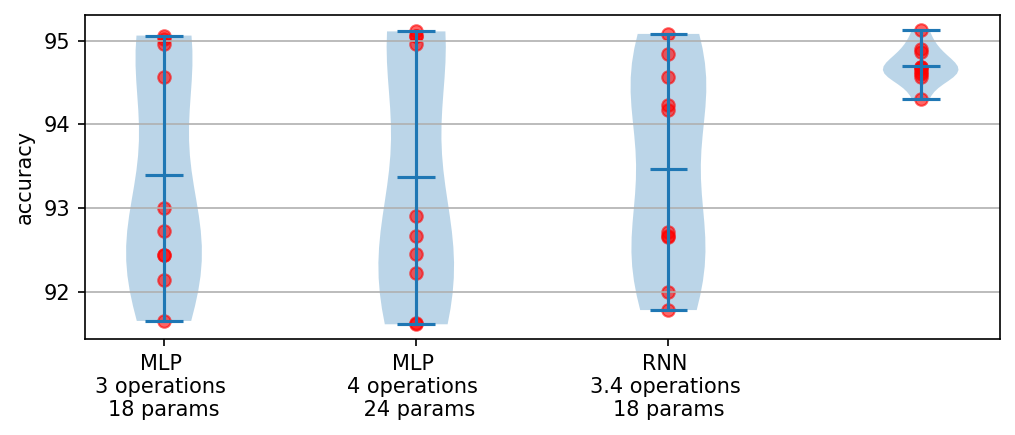

In [29]:
plt.figure(figsize=(7, 3), dpi=150)

make_violin_plot([acc_mlp2, acc_mlp3] + acc_rnn)

plt.xticks([0, 1, 2], ['MLP \n3 operations \n18 params', 'MLP \n4 operations \n 24 params', 'RNN \n3.4 operations \n18 params'])
plt.ylabel('accuracy')
plt.tight_layout()
plt.grid(visible=True, axis='y')
plt.savefig(os.path.join(result_dir, 'images/synth2d_violin'))

In [12]:
import scipy
scipy.stats.ttest_ind(acc_mlp3, acc_rnn, equal_var=False)

Ttest_indResult(statistic=-2.927722454650446, pvalue=0.009048194363445975)

13
13


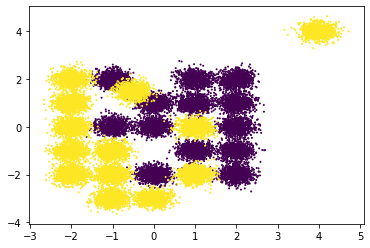

In [47]:
data = []
target = []

centers = np.array([[2, 2], [2, 1], [1, 2], [1, 1], [2, 0], [1, -1], [2, -2], [0, 1], [0, -2],
                    [-1, 2], [-1, 0], [0, 0], [2, -1]])
print(len(centers))
for c in centers:
    data.append(c + np.random.randn(1000, 2) / 5)
    target += [0] * 1000
    
centers = np.array([[-2, -2], [-2, -1], [-1, -2], [-1, -1], [1, 0], [-2, 0], [1, -2], [-2, 1],
                    [-.5, 1.5], [-2, 2], [0, -3], [-1, -3], [4, 4]])
print(len(centers))

for c in centers:
    data.append(c + np.random.randn(1000, 2) / 5)
    target += [1] * 1000
    
    
data = np.concatenate(data, axis=0)    

plt.scatter(data[:, 0], data[:, 1], c=target, s=1)